In [1]:
# load all libraries reqd for the project
#Steps for the project
#1.Camera calibration - done
#2.Distortion correction - done
#3.Color/gradient threshold - done
#4.Perspective transform - done
#5.Detect lane lines
#6.Determine the lane curvature
import numpy as np
import cv2
import scipy.ndimage as snd
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
# Calibrate Camera
nx, ny = 9, 6
objp = np.zeros((nx*ny,3),np.float32) # 3d real world space
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
objpts = [] # 3d real world space
imgpts = [] # 2d corners
inames = glob.glob('camera_cal/calibration*.jpg')
#plt.imshow(snd.imread(inames[0]))
for iimage in range(len(inames)):
    #plt.imshow(snd.imread(inames[5]))
    img = snd.imread(inames[iimage])
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #plt.imshow(gray)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    #print(ret)
    if ret == True:
        objpts.append(objp)
        imgpts.append(corners)
        #iimg = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #plt.imshow(iimg)

# return camera matrix (mtx), distortion coefficients (dist)
retc, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts,imgpts,img.shape[0:2],None,None)
"""img = snd.imread(inames[5])
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(img)
undistort = cv2.undistort(img,mtx,dist,None,mtx)
ax2.imshow(undistort)
"""

'img = snd.imread(inames[5])\nf, (ax1, ax2) = plt.subplots(1,2)\nax1.imshow(img)\nundistort = cv2.undistort(img,mtx,dist,None,mtx)\nax2.imshow(undistort)\n'

In [3]:
# define all sobel and color space functions for edge detection and combine them to get results like canny edge detection
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray,cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= np.min(mag_thresh)) & (scaled_sobel <= np.max(mag_thresh))] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return mag_binary
    
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_gradient = np.arctan2(abs_sobely,abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(dir_gradient)
    dir_binary[(dir_gradient >= np.min(thresh)) & (dir_gradient <= np.max(thresh))] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return dir_binary

def color_threshold(img, thresh = (0,255), hlschannel = 's'):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    if hlschannel == 's':
        color = 2 # saturation
    elif hlschannel == 'l':
        color = 1 # lightness
    else:
        color = 0 # hue
        
    c_channel = hls[:,:,color]
    c_binary = np.zeros_like(c_channel)
    c_binary[(c_channel >= np.min(thresh)) & (c_channel <= np.max(thresh))] = 1
    
    return c_binary

In [11]:
def find_edges(undist):
    gradx = abs_sobel_thresh(undist, orient = 'x', thresh_min=30, thresh_max=100) # 20,100
    #grady = abs_sobel_thresh(undist, orient = 'y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(undist, sobel_kernel=5, mag_thresh=(30, 100)) # 30,100
    dir_binary = dir_threshold(undist, sobel_kernel=15, thresh=(0.7, 1.3)) # 0.7,1.3
    s_binary   = color_threshold(undist,thresh=(170,255), hlschannel = 's') #90,255 # yellow line
    l_binary   = color_threshold(undist,thresh=(220,255), hlschannel = 'l') #220,255 # white line 
    shadow_binary = color_threshold(undist,thresh=(0,150), hlschannel = 'l') #0,25 # white line 
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1)) | (col_binary == 1)] = 1
    # including grady makes it difficult to get far lines
    #combined[((gradx == 1) ) & ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    #combined[((gradx == 1) ) & ((mag_binary == 1) & (dir_binary == 1)) | (l_binary == 1)] = 1 # white line
    #combined[(gradx == 1) | (col_binary == 1)] = 1
    combined[((gradx == 1) | ((s_binary == 1) | (l_binary == 1)))] = 1
    #combined[(gradx == 1) | ((s_binary == 1) | (l_binary == 1) & (~shadow_binary == 1))] = 1
    return combined

def lane_lines_source_pts(edges_image):
    # inspiration from project P1
    # mask the image
    mask = np.zeros_like(edges_image)   
    ignore_mask_color = 255
    imshape = edges_image.shape
    # vertical axis minimum and maximum horizon for line extrapolation
    ymax   = imshape[0]
    ymin   = np.int(np.round(ymax/1.6))
    
    vertices = np.array([[(0,ymax-50),(imshape[1]/2.6, ymin),\
                                                (imshape[1]/1.5, ymin),(imshape[1],ymax-50)]], dtype=np.int32)
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    edges_roi = cv2.bitwise_and(edges_image*255, mask)
    # generate hough lines
    threshold, min_line_len, max_line_gap = 20, 15, 5
    lines = cv2.HoughLinesP(np.uint8(edges_roi), 1, np.pi/180, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*edges_image.shape, 3), dtype=np.uint8)
    
    # Find lines of interest and combine them to get edges of line
    rFit = []
    lFit = []
    lLength = []
    rLength = []
    offset = 50 # to allow for selection of turn lines to be on just a bit left or right of center
    for line in lines:
        for x1,y1,x2,y2 in line:
            slopeLine = ((y2-y1)/(x2-x1))
            if (slopeLine > 0.5 and x1 > (imshape[0]/2-offset) and x2 > (imshape[0]/2-offset)): # right lane
                print('{}-x1 {}-y1 {}-x2 {}-y2'.format(x1,y1,x2,y2))
                rFit.append(np.polyfit((x1,x2), (y1,y2),1))
                rLength.append(np.sqrt(np.square(x2-x1)+np.square(y2-y1)))
            elif (slopeLine < -0.5 and x1 < (imshape[0]/2+offset) and x2 < (imshape[0]/2+offset)): # left lane 
                lFit.append(np.polyfit((x1,x2),(y1,y2),1))
                lLength.append(np.sqrt(np.square(x2-x1)+np.square(y2-y1)))
    lFit = np.asarray(lFit)
    rFit = np.asarray(rFit)
    lLength = np.asarray(lLength)
    rLength = np.asarray(rLength)
    lSort = np.zeros((lLength.size,3))
    rSort = np.zeros((rLength.size,3))
    
    # sort according to line length
    if (lFit.shape[0] != 0 and rFit.shape[0] != 0):
        lSort[:,1:] = lFit
        lSort[:,0] = lLength
        lSort = np.array(lSort)
        lSort = lSort[np.argsort(lSort[:,0])]
        rSort[:,1:] = rFit
        rSort[:,0] = rLength
        rSort = np.array(rSort)
        rSort = rSort[np.argsort(rSort[:,0])]
        # average with weighting according to line length, bigger line length - more the weight
        lAvg = [np.average(lSort[:,1],weights=np.arange(1,(lSort.shape)[0]+1,1)), \
                np.average(lSort[:,2],weights=np.arange(1,(lSort.shape)[0]+1,1))]
        rAvg = [np.average(rSort[:,1],weights=np.arange(1,(rSort.shape)[0]+1,1)), \
                np.average(rSort[:,2],weights=np.arange(1,(rSort.shape)[0]+1,1))]
        x2lAvg = np.int((ymin-lAvg[1])/lAvg[0])
        x1lAvg = np.int((ymax-lAvg[1])/lAvg[0])
        x2rAvg = np.int((ymin-rAvg[1])/rAvg[0])
        x1rAvg = np.int((ymax-rAvg[1])/rAvg[0])
        
    else:
        x1lAvg, x2lAvg, x2rAvg, x1rAvg = 200, 550, 750, 1100 
    '''   
    elif (lFit.shape[0]==0 and rFit.shape[0]!=0):
        
        rSort[:,1:] = rFit
        rSort[:,0] = rLength
        rSort = np.array(rSort)
        rSort = rSort[np.argsort(rSort[:,0])]

        # average with weighting according to line length, bigger line length - more the weight
        rAvg = [np.average(rSort[:,1],weights=np.arange(1,(rSort.shape)[0]+1,1)), \
                np.average(rSort[:,2],weights=np.arange(1,(rSort.shape)[0]+1,1))]

        x2rAvg = np.int((ymin-rAvg[1])/rAvg[0])
        x1rAvg = np.int((ymax-rAvg[1])/rAvg[0])
        rslope = -(ymax-ymin)/(x1rAvg-x2rAvg)
        x1lAvg = x1rAvg-900 # assumed distance between 2 lanes is 900 pixels
        x2lAvg = ((ymin-ymax)/rslope)+x1lAvg

    elif (lFit.shape[0]!=0 and rFit.shape[0]==0):
        lSort[:,1:] = lFit
        lSort[:,0] = lLength
        lSort = np.array(lSort)
        lSort = lSort[np.argsort(lSort[:,0])]
        
        # average with weighting according to line length, bigger line length - more the weight
        lAvg = [np.average(lSort[:,1],weights=np.arange(1,(lSort.shape)[0]+1,1)), \
                np.average(lSort[:,2],weights=np.arange(1,(lSort.shape)[0]+1,1))]

        x2lAvg = np.int((ymin-lAvg[1])/lAvg[0])
        x1lAvg = np.int((ymax-lAvg[1])/lAvg[0])
        lslope = -(ymax-ymin)/(x1lAvg-x2lAvg)
        x1rAvg = x1lAvg + 900 # assumed distance between 2 lanes is 900 pixels
        x2rAvg = ((ymin-ymax)/lslope)+x1rAvg ''' 
    
    corners = np.float32([[x1lAvg, ymax], [x2lAvg, ymin],[x2rAvg, ymin],[x1rAvg, ymax]])
    return corners

In [12]:
def corners_unwarp(img, mtx, dist):
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2) Convert to canny edge style white edges for finding lane lines
    combined = find_edges(undist)
    
    #gray = combined
    # 3) Find the corners
    # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
    # get current image src points for unwarping -- done automatically
    src = lane_lines_source_pts(combined)
    #offset = 100 # offset for dst points
    img_size = (combined.shape[1], combined.shape[0])
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[src[0,0], img_size[1]], 
                     [src[0,0], 0], 
                     [src[3,0], 0],
                     [src[3,0], img_size[1]]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    #delete the next two lines
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv, undist, combined, src, dst

In [13]:
#get radius of curvature
def curverad_and_distance_tocentre(image,ploty,left_fitx,right_fitx):
    y_eval = np.max(ploty) # max value of y corresponding to bottom of image
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad) in pixels

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature in meters
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    # distance to center in meters
    screen_middel_pixel = image.shape[1]//2
    car_middle_pixel = int((left_fitx[-1] + right_fitx[-1])//2)
    screen_off_center = screen_middel_pixel-car_middle_pixel
    dist_to_center = xm_per_pix * screen_off_center #pixels_off_center (+ve, right and -ve left)
    
    return left_curverad, right_curverad, dist_to_center

# Create an image to draw the lines on
def image_with_laneline(undist,lanes,left_fitx,right_fitx,ploty,Minv,left_curverad,right_curverad,dist_to_center):
    warp_zero = np.zeros_like(lanes).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #put text in result image
    if dist_to_center<0:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(abs(dist_to_center)), (100,80),fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(dist_to_center), (100,80),fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'Left Curvature is {:.0f}m'.format(left_curverad), (100,160),fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'Right Curvature is {:.0f}m'.format(right_curverad), (100,240),fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    
    return result

In [14]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width = 50, window_height = 80, margin = 100):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    #temp_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    if sum(conv_signal[l_min_index:l_max_index])>0:
	        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    if sum(conv_signal[r_min_index:r_max_index])>0:
	        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))
        
    return window_centroids

def overlay_window_centroids_with_image(window_centroids,lanes,window_width, window_height):
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(lanes)
        r_points = np.zeros_like(lanes)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,lanes,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,lanes,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((lanes,lanes,lanes)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((lanes,lanes,lanes)),np.uint8)
        
    return output

def filtered_and_fit_laneline(binary_combined,window_centroids,y_centroids):
    # draw the lines
    window_centroids_array = np.asarray(window_centroids)
    leftx    = np.flipud(window_centroids_array[:,0]) # so that the x starts from top of image
    rightx   = np.flipud(window_centroids_array[:,1]) # so that the x starts from top of image
    
    # reject outliers
    y_mu, y_sig = np.mean(y_centroids), np.std(y_centroids)
    xl_mu, xl_sig = np.mean(leftx), np.std(leftx)
    xr_mu, xr_sig = np.mean(rightx), np.std(rightx)
    print(rightx)
    leftx_f, lefty_f = zip(*[(x, y) for (x,y) in zip(leftx, y_centroids) 
                                 if abs(x - xl_mu) < 2*xl_sig and abs(y - y_mu) < 2*y_sig])
    rightx_f, righty_f = zip(*[(x, y) for (x,y) in zip(rightx, y_centroids) 
                                 if abs(x - xr_mu) < 2*xr_sig and abs(y - y_mu) < 2*y_sig])
    
    # reject outlier - method 2
    dl = [np.diff(leftx_f)]
    dl = np.append(dl,0)
    dr = [np.diff(rightx_f)]
    dr = np.append(dr,0)
    while (np.logical_or((dr>=100),(dr<=-100))).any() or (np.logical_or((dl>=100),(dl<=-100))).any():
        flag = np.ones_like(dr,dtype=bool)
        flag[np.logical_or((dr>=100),(dr<=-100))] = False
        rightx_f, righty_f = np.asarray(rightx_f)[flag], np.asarray(righty_f)[flag]
        flag = np.ones_like(dl,dtype = bool)
        flag[np.logical_or((dl>=100),(dl<=-100))] = False
        leftx_f, lefty_f = np.asarray(leftx_f)[flag], np.asarray(lefty_f)[flag]
        dl = [np.diff(leftx_f)]
        dl = np.append(dl,0)
        dr = [np.diff(rightx_f)]
        dr = np.append(dr,0)
        
    # fit the line
    left_fit = np.polyfit(lefty_f,leftx_f,2)
    right_fit = np.polyfit(righty_f,rightx_f,2)
    #generate a line
    ploty = np.linspace(0, binary_combined.shape[0]-1, binary_combined.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

In [1]:
# TRY ON SAMPLE IMAGES especially edge detection parts
onames = glob.glob('test_images/*.jpg')
image = snd.imread(onames[4]) # problem images is 2,5 .. 6 maybe
#f, (ax3,ax4) = plt.subplots(1,2)
#ax3.imshow(image)
undist = cv2.undistort(image, mtx, dist, None, mtx)
gradx = abs_sobel_thresh(undist, orient = 'x', thresh_min=30, thresh_max=100) # 20,100
grady = abs_sobel_thresh(undist, orient = 'y', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(undist, sobel_kernel=5, mag_thresh=(30, 100)) # 30,100
dir_binary = dir_threshold(undist, sobel_kernel=15, thresh=(0.7, 1.3)) # 0.7,1.3
s_binary   = color_threshold(undist,thresh=(170,255), hlschannel = 's') #90,255 # yellow line
l_binary   = color_threshold(undist,thresh=(220,255), hlschannel = 'l') #220,255 # white line 
combined = np.zeros_like(dir_binary)
#c_binary   = color_threshold(undist,thresh=(0,75), hlschannel = 'l') #220,255 # white line 
#combined[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
# including grady makes it difficult to get far lines
combined[((gradx == 1) | (s_binary == 1) | (l_binary == 1))] = 1
#combined[(((gradx ==1) | (grady==1)) | ((mag_binary == 1) & (dir_binary == 1)))] = 1
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(undist,cmap = 'gray')

plt.subplot(1, 2, 2)
plt.imshow(combined,cmap = 'gray')
image.shape

NameError: name 'glob' is not defined

849-x1 546-y1 978-x2 620-y2
857-x1 544-y1 985-x2 621-y2
850-x1 543-y1 979-x2 620-y2
852-x1 543-y1 981-x2 620-y2
864-x1 555-y1 969-x2 620-y2
907-x1 580-y1 972-x2 620-y2
915-x1 578-y1 940-x2 593-y2
736-x1 467-y1 751-x2 482-y2
935-x1 596-y1 974-x2 620-y2
887-x1 570-y1 967-x2 620-y2
856-x1 547-y1 968-x2 619-y2
888-x1 562-y1 908-x2 574-y2
748-x1 474-y1 767-x2 487-y2
740-x1 474-y1 760-x2 486-y2
893-x1 572-y1 921-x2 591-y2
848-x1 544-y1 880-x2 563-y2


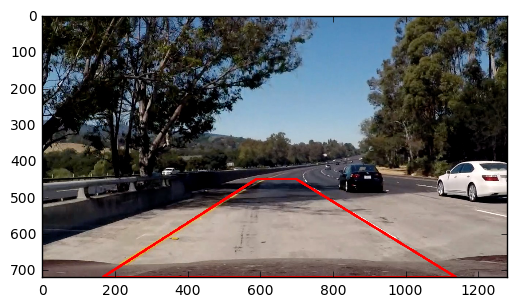

In [26]:
lanes, perspective_M, Minv, undist, binary_combined, src, dst = corners_unwarp(image, mtx, dist)
#ax5.imshow(image)
#ax5.imshow(cv2.line(image,tuple(dst[0,:]),tuple(dst[1,:]),(0,255,255),5))
points = np.array(src,dtype = np.int32)
plt.imshow(cv2.polylines(image,[points],1,(255,0,0),thickness = 5))

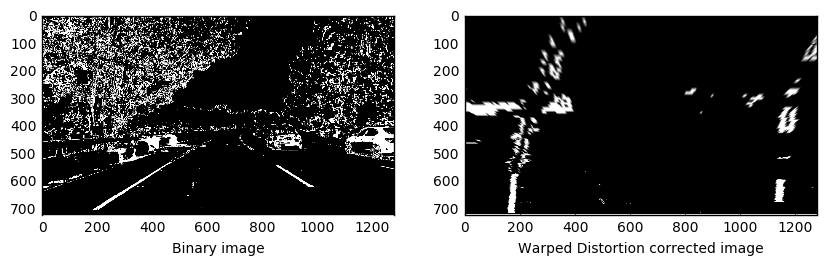

[[  166.   720.]
 [  589.   450.]
 [  697.   450.]
 [ 1137.   720.]]


In [27]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(binary_combined,cmap = 'gray')
plt.xlabel('Binary image')

plt.subplot(1, 2, 2)
plt.imshow(lanes,cmap = 'gray')
plt.xlabel('Warped Distortion corrected image')
plt.show()
print(src)

[(179.0, 1142.0), (182.0, 1142.0), (203.0, 1156.0), (204.0, 1162.0), (104.0, 1171.0), (193.0, 1185.0), (292.0, 1222.0), (331.0, 1254.0), (369.0, 1254.0)]
[ 369.  331.  292.  193.  204.  203.  182.  179.]
[ 1254.  1254.  1222.  1185.  1171.  1162.  1156.  1142.  1142.]


(720, 0)

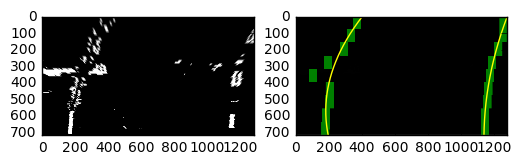

In [28]:
# Find lanes lines from binary_warped image
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
window_centroids = find_window_centroids(lanes, window_width, window_height, margin)
print(window_centroids)
y_centroids = np.arange(window_height/2,lanes.shape[0],window_height)

# Display the final results
f, (ax7,ax8) = plt.subplots(1,2)
ax7.imshow(lanes,cmap = 'gray')
output = overlay_window_centroids_with_image(window_centroids,lanes,window_width, window_height)
ax8.imshow(output)

# draw the lines
window_centroids_array = np.asarray(window_centroids)
leftx    = np.flipud(window_centroids_array[:,0])
rightx   = np.flipud(window_centroids_array[:,1])

# reject outliers - method 1
y_mu, y_sig = np.mean(y_centroids), np.std(y_centroids)
xl_mu, xl_sig = np.mean(leftx), np.std(leftx)
xr_mu, xr_sig = np.mean(rightx), np.std(rightx)

leftx_f, lefty_f = zip(*[(x, y) for (x,y) in zip(leftx, y_centroids) 
                                 if abs(x - xl_mu) < 2*xl_sig and abs(y - y_mu) < 2*y_sig])
rightx_f, righty_f = zip(*[(x, y) for (x,y) in zip(rightx, y_centroids) 
                                 if abs(x - xr_mu) < 2*xr_sig and abs(y - y_mu) < 2*y_sig])
# reject outlier - method 2 -- maybe not required
dl = [np.diff(leftx_f)]
dl = np.append(dl,0)
dr = [np.diff(rightx_f)]
dr = np.append(dr,0)
while (np.logical_or((dr>=100),(dr<=-100))).any() or (np.logical_or((dl>=100),(dl<=-100))).any() :
    flag = np.ones_like(dr,dtype=bool)
    flag[np.logical_or((dr>=100),(dr<=-100))] = False
    rightx_f, righty_f = np.asarray(rightx_f)[flag], np.asarray(righty_f)[flag]
    flag = np.ones_like(dl,dtype = bool)
    flag[np.logical_or((dl>=100),(dl<=-100))] = False
    leftx_f, lefty_f = np.asarray(leftx_f)[flag], np.asarray(lefty_f)[flag]
    dl = [np.diff(leftx_f)]
    dl = np.append(dl,0)
    dr = [np.diff(rightx_f)]
    dr = np.append(dr,0)
print(leftx_f)
print(rightx_f)
left_fit = np.polyfit(lefty_f,leftx_f,2)
right_fit = np.polyfit(righty_f,rightx_f,2)
#generate a line
ploty = np.linspace(0, binary_combined.shape[0]-1, binary_combined.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

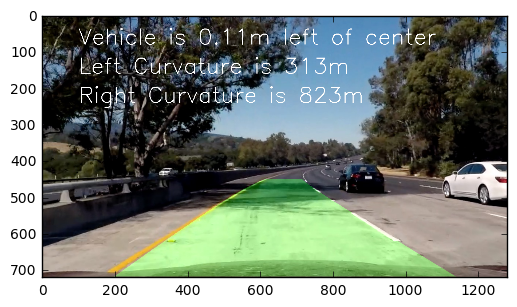

In [29]:
left_curverad,right_curverad, dist_to_center = curverad_and_distance_tocentre(lanes,ploty,left_fitx,right_fitx)
result = image_with_laneline(undist,lanes,left_fitx,right_fitx,ploty,Minv,left_curverad,right_curverad,dist_to_center)
plt.imshow(result)

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
def process_image(image,mtx,dst):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here, you should return the final output (image with lines are drawn on lanes and text about curvature and dist to cent)
    
    # get edges after doing image undistortion, lane edges and perspective warping (bird's eye view)
    lanes, perspective_M, Minv, undist, binary_combined, src, dst = corners_unwarp(image, mtx, dist)
    
    # find the lane lines from the edges found in above algorithm
    window_centroids = find_window_centroids(lanes, window_width = 50, window_height = 80, margin = 100)
    y_centroids = np.arange(window_height/2,lanes.shape[0],window_height)
    
    # fitting to generate laneline from the centroids detected by historgram algorithm
    ploty, left_fitx, right_fitx = filtered_and_fit_laneline(binary_combined,window_centroids,y_centroids)

    # get the left lane radius, right lane radius and distance of vehicle from center of its lane
    left_curverad,right_curverad, dist_to_center = curverad_and_distance_tocentre(lanes,ploty,left_fitx,right_fitx)
    
    # draw the image with lane lines and the text of radius and distance
    result = image_with_laneline(undist,lanes,left_fitx,right_fitx,ploty,Minv,left_curverad,right_curverad,dist_to_center)

    return result

In [34]:
output = 'result_project_video.mp4'
#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("project_video.mp4").subclip((0,24),(0,30))
output_clip = clip1.fl_image(lambda image: process_image(image,mtx,dst)) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

763-x1 490-y1 800-x2 510-y2
778-x1 494-y1 806-x2 511-y2
768-x1 490-y1 801-x2 510-y2
766-x1 490-y1 797-x2 511-y2
764-x1 491-y1 783-x2 503-y2
771-x1 490-y1 804-x2 511-y2
770-x1 490-y1 787-x2 501-y2
[ 1188.  1153.  1152.  1155.  1197.  1144.  1146.  1146.  1146.]
[MoviePy] >>>> Building video result_project_video.mp4
[MoviePy] Writing video result_project_video.mp4



  0%|          | 0/151 [00:00<?, ?it/s]

763-x1 490-y1 800-x2 510-y2
778-x1 494-y1 806-x2 511-y2
768-x1 490-y1 801-x2 510-y2
766-x1 490-y1 797-x2 511-y2
764-x1 491-y1 783-x2 503-y2
771-x1 490-y1 804-x2 511-y2
770-x1 490-y1 787-x2 501-y2
[ 1188.  1153.  1152.  1155.  1197.  1144.  1146.  1146.  1146.]



  1%|          | 1/151 [00:00<00:56,  2.67it/s]

771-x1 494-y1 818-x2 518-y2
791-x1 506-y1 812-x2 518-y2
777-x1 494-y1 819-x2 518-y2
789-x1 499-y1 820-x2 517-y2
771-x1 492-y1 788-x2 502-y2
775-x1 497-y1 815-x2 518-y2
774-x1 493-y1 802-x2 509-y2
[ 1254.  1254.  1246.  1229.  1223.  1191.  1184.  1176.  1176.]



  1%|▏         | 2/151 [00:00<00:56,  2.64it/s]

786-x1 500-y1 830-x2 528-y2
787-x1 500-y1 834-x2 528-y2
788-x1 500-y1 839-x2 529-y2
781-x1 498-y1 827-x2 527-y2
781-x1 500-y1 797-x2 510-y2
781-x1 499-y1 826-x2 528-y2
823-x1 519-y1 838-x2 528-y2
799-x1 505-y1 816-x2 515-y2
[ 1196.  1156.  1156.  1139.  1154.  1148.  1148.  1151.  1151.]



  2%|▏         | 3/151 [00:01<00:55,  2.65it/s]

793-x1 506-y1 851-x2 540-y2
795-x1 506-y1 852-x2 540-y2
811-x1 514-y1 854-x2 540-y2
792-x1 506-y1 849-x2 540-y2
813-x1 514-y1 833-x2 526-y2
792-x1 507-y1 846-x2 539-y2
816-x1 515-y1 833-x2 525-y2
1020-x1 636-y1 1037-x2 645-y2
796-x1 506-y1 838-x2 531-y2
[ 1249.  1224.  1184.  1178.  1172.  1172.  1158.  1158.  1156.]



  3%|▎         | 4/151 [00:01<00:56,  2.59it/s]

806-x1 518-y1 878-x2 558-y2
805-x1 515-y1 881-x2 558-y2
809-x1 516-y1 885-x2 559-y2
826-x1 524-y1 849-x2 538-y2
864-x1 546-y1 886-x2 559-y2
805-x1 516-y1 861-x2 552-y2
815-x1 521-y1 850-x2 542-y2
845-x1 541-y1 877-x2 558-y2
825-x1 523-y1 844-x2 534-y2
808-x1 517-y1 871-x2 557-y2
[ 1254.  1254.  1233.  1193.  1189.  1176.  1163.  1159.  1160.]



  3%|▎         | 5/151 [00:01<00:56,  2.58it/s]

818-x1 527-y1 907-x2 580-y2
825-x1 528-y1 914-x2 579-y2
819-x1 528-y1 904-x2 579-y2
822-x1 528-y1 912-x2 580-y2
851-x1 540-y1 914-x2 578-y2
902-x1 570-y1 921-x2 582-y2
866-x1 558-y1 902-x2 580-y2
841-x1 535-y1 882-x2 560-y2
857-x1 547-y1 885-x2 564-y2
822-x1 531-y1 902-x2 579-y2
862-x1 552-y1 908-x2 580-y2
705-x1 450-y1 728-x2 469-y2
[ 1245.  1236.  1200.  1162.  1158.  1152.  1194.  1146.  1146.]



  4%|▍         | 6/151 [00:02<00:55,  2.61it/s]

843-x1 546-y1 964-x2 610-y2
836-x1 541-y1 968-x2 611-y2
844-x1 541-y1 959-x2 605-y2
873-x1 564-y1 955-x2 608-y2
837-x1 540-y1 910-x2 579-y2
873-x1 556-y1 910-x2 577-y2
888-x1 573-y1 954-x2 608-y2
873-x1 555-y1 894-x2 567-y2
919-x1 583-y1 964-x2 608-y2
862-x1 554-y1 943-x2 607-y2
926-x1 593-y1 941-x2 602-y2
909-x1 579-y1 930-x2 590-y2
709-x1 455-y1 730-x2 472-y2
880-x1 565-y1 932-x2 598-y2
[ 1254.  1254.  1254.  1250.  1218.  1201.  1185.  1161.  1158.]



  5%|▍         | 7/151 [00:02<00:56,  2.56it/s]

879-x1 568-y1 1027-x2 647-y2
857-x1 552-y1 1031-x2 648-y2
861-x1 553-y1 964-x2 610-y2
979-x1 617-y1 1031-x2 647-y2
905-x1 584-y1 1013-x2 642-y2
920-x1 593-y1 1012-x2 642-y2
957-x1 615-y1 1013-x2 645-y2
864-x1 553-y1 951-x2 601-y2
940-x1 605-y1 1009-x2 642-y2
857-x1 553-y1 1017-x2 641-y2
992-x1 624-y1 1011-x2 635-y2
894-x1 577-y1 1016-x2 642-y2
862-x1 556-y1 887-x2 572-y2
968-x1 622-y1 1013-x2 647-y2
903-x1 574-y1 930-x2 589-y2
868-x1 553-y1 894-x2 568-y2
708-x1 450-y1 734-x2 474-y2
903-x1 573-y1 926-x2 586-y2
857-x1 554-y1 968-x2 615-y2
707-x1 452-y1 730-x2 472-y2
985-x1 633-y1 1002-x2 642-y2
[ 1254.  1254.  1254.  1254.  1254.  1254.  1237.  1208.  1161.]



  5%|▌         | 8/151 [00:03<00:55,  2.56it/s]

884-x1 571-y1 1056-x2 670-y2
890-x1 570-y1 1041-x2 657-y2
884-x1 569-y1 1056-x2 668-y2
927-x1 598-y1 1051-x2 670-y2
885-x1 572-y1 1054-x2 670-y2
893-x1 570-y1 973-x2 616-y2
941-x1 596-y1 974-x2 616-y2
1038-x1 653-y1 1058-x2 665-y2
956-x1 616-y1 1050-x2 670-y2
941-x1 595-y1 973-x2 614-y2
1001-x1 643-y1 1047-x2 670-y2
897-x1 580-y1 1053-x2 670-y2
887-x1 570-y1 1056-x2 667-y2
889-x1 570-y1 1043-x2 659-y2
1016-x1 640-y1 1068-x2 670-y2
986-x1 624-y1 1005-x2 635-y2
723-x1 467-y1 739-x2 476-y2
[ 1254.  1254.  1254.  1254.  1254.  1213.  1195.  1177.  1147.]



  6%|▌         | 9/151 [00:03<00:56,  2.50it/s]

919-x1 592-y1 1055-x2 670-y2
934-x1 603-y1 1048-x2 669-y2
1005-x1 639-y1 1055-x2 669-y2
1007-x1 639-y1 1040-x2 657-y2
925-x1 592-y1 981-x2 623-y2
918-x1 592-y1 1051-x2 669-y2
1011-x1 640-y1 1059-x2 667-y2
927-x1 592-y1 973-x2 617-y2
994-x1 627-y1 1066-x2 670-y2
921-x1 592-y1 1054-x2 669-y2
966-x1 623-y1 1047-x2 670-y2
924-x1 593-y1 975-x2 620-y2
1000-x1 644-y1 1045-x2 670-y2
990-x1 626-y1 1051-x2 662-y2
929-x1 596-y1 997-x2 633-y2
936-x1 594-y1 954-x2 605-y2
1008-x1 640-y1 1058-x2 670-y2
728-x1 468-y1 743-x2 478-y2
1028-x1 651-y1 1060-x2 670-y2
919-x1 594-y1 1049-x2 669-y2
931-x1 593-y1 951-x2 604-y2
483-x1 460-y1 498-x2 469-y2
[ 1254.  1254.  1254.  1254.  1254.  1236.  1205.  1178.  1148.]



  7%|▋         | 10/151 [00:03<00:55,  2.52it/s]

966-x1 623-y1 1047-x2 670-y2
967-x1 622-y1 1058-x2 670-y2
972-x1 623-y1 1055-x2 667-y2
965-x1 622-y1 1055-x2 670-y2
981-x1 622-y1 1010-x2 640-y2
968-x1 625-y1 1046-x2 670-y2
974-x1 622-y1 996-x2 634-y2
730-x1 470-y1 745-x2 479-y2
1018-x1 656-y1 1043-x2 670-y2
1006-x1 639-y1 1034-x2 655-y2
976-x1 622-y1 1006-x2 638-y2
708-x1 450-y1 725-x2 462-y2
475-x1 465-y1 491-x2 474-y2
993-x1 629-y1 1010-x2 639-y2
973-x1 623-y1 1010-x2 642-y2
475-x1 463-y1 492-x2 474-y2
980-x1 623-y1 996-x2 633-y2
980-x1 628-y1 1048-x2 670-y2
993-x1 641-y1 1044-x2 670-y2
[ 1254.  1254.  1254.  1254.  1254.  1254.  1254.  1205.  1142.]



  7%|▋         | 11/151 [00:04<00:59,  2.37it/s]

732-x1 474-y1 752-x2 486-y2
733-x1 473-y1 752-x2 485-y2
737-x1 473-y1 752-x2 483-y2
[ 1231.  1206.  1169.  1146.  1125.  1106.  1118.  1123.  1123.]



  8%|▊         | 12/151 [00:04<00:58,  2.39it/s]

706-x1 450-y1 722-x2 461-y2
737-x1 476-y1 756-x2 490-y2
742-x1 476-y1 758-x2 487-y2
741-x1 478-y1 757-x2 490-y2
741-x1 476-y1 758-x2 490-y2
[ 652.  652.  652.  652.  652.  652.  652.  652.  652.]


ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
base_pts, hist = find_base_points(lanes)
print(base_pts)

# plt.figure(figsize=(5,3))
plt.axes([0, 0.6, 0.5, 0.5])
plt.plot(hist)
plt.ylim([0, 500])
plt.xlim([0, 1280])
plt.xlabel('Histogram')
plt.ylabel('Number of pixels')

plt.figure()
plt.imshow(binary_combined, cmap='gray')
plt.xlabel('Thresholded, warped image')
plt.xticks([],[])
plt.yticks([],[])
plt.show()

In [ ]:
# Previous algorithm
def lane_lines_source_pts(edges_image):
    # inspiration from project P1
    # mask the image
    mask = np.zeros_like(edges_image)   
    ignore_mask_color = 255
    imshape = edges_image.shape
    vertices = np.array([[(0,imshape[0]-50),(imshape[1]/2.6, imshape[0]/1.6),\
                                                (imshape[1]/1.3, imshape[0]/1.6),(imshape[1],imshape[0]-50)]], dtype=np.int32)
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    edges_roi = cv2.bitwise_and(edges_image*255, mask)
    
    # generate hough lines
    threshold, min_line_len, max_line_gap = 15, 20, 5
    lines = cv2.HoughLinesP(np.uint8(edges_roi), 1, np.pi/180, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*edges_image.shape, 3), dtype=np.uint8)
    
    # Find lines of interest and combine them to get edges of line
    rFit = []
    lFit = []
    lLength = []
    rLength = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slopeLine = ((y2-y1)/(x2-x1))
            if slopeLine > 0.5: # right lane
                rFit.append(np.polyfit((x1,x2), (y1,y2),1))
                rLength.append(np.sqrt(np.square(x2-x1)+np.square(y2-y1)))
            elif slopeLine < -0.5: # left lane 
                lFit.append(np.polyfit((x1,x2),(y1,y2),1))
                lLength.append(np.sqrt(np.square(x2-x1)+np.square(y2-y1)))
    lFit = np.asarray(lFit)
    rFit = np.asarray(rFit)
    lLength = np.asarray(lLength)
    rLength = np.asarray(rLength)
    lSort = np.zeros((lLength.size,3))
    rSort = np.zeros((rLength.size,3))
    # vertical axis minimum and maximum horizon for line extrapolation
    ymax   = imshape[0]
    ymin   = np.int(np.round(ymax/1.6))
    
    # sort according to line length
    if (lFit.shape[0] != 0 and rFit.shape[0] != 0):
        lSort[:,1:] = lFit
        lSort[:,0] = lLength
        lSort = np.array(lSort)
        lSort = lSort[np.argsort(lSort[:,0])]
        rSort[:,1:] = rFit
        rSort[:,0] = rLength
        rSort = np.array(rSort)
        rSort = rSort[np.argsort(rSort[:,0])]

        # average with weighting according to line length, bigger line length - more the weight
        lAvg = [np.average(lSort[:,1],weights=np.arange(1,(lSort.shape)[0]+1,1)), \
                np.average(lSort[:,2],weights=np.arange(1,(lSort.shape)[0]+1,1))]
        rAvg = [np.average(rSort[:,1],weights=np.arange(1,(rSort.shape)[0]+1,1)), \
                np.average(rSort[:,2],weights=np.arange(1,(rSort.shape)[0]+1,1))]
        #print(rSort)

        x2lAvg = np.int((ymin-lAvg[1])/lAvg[0])
        x1lAvg = np.int((ymax-lAvg[1])/lAvg[0])
        x2rAvg = np.int((ymin-rAvg[1])/rAvg[0])
        x1rAvg = np.int((ymax-rAvg[1])/rAvg[0])
        
        corners = np.float32([[x1lAvg, ymax],
                              [x2lAvg, ymin],
                              [x2rAvg, ymin],
                              [x1rAvg, ymax]])
    else:
        corners = np.float32([[200, ymax], [550, ymin], [750, ymin], [1100, ymax]])
            
    return corners